In [59]:
import numpy as np
import core.vem as vem
from typing import Tuple

# geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[1,2]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.16360817e-04
 -3.20308731e-04 -8.04745594e-04  5.44061872e-05 -3.46357935e-04
  6.33978590e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
#########################################################


In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, ndof):
        super(BeamApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, ndof)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
model = BeamApproximator(input_dim, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

In [61]:
epochs = 4000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 526466744320.0
Epoch: 2, Loss: 3493435539456.0
Epoch: 3, Loss: 513845493760.0
Epoch: 4, Loss: 119273758720.0
Epoch: 5, Loss: 505440239616.0
Epoch: 6, Loss: 575335956480.0
Epoch: 7, Loss: 434248450048.0
Epoch: 8, Loss: 290677030912.0
Epoch: 9, Loss: 174753382400.0
Epoch: 10, Loss: 88618524672.0
Epoch: 11, Loss: 35738173440.0
Epoch: 12, Loss: 9529542656.0
Epoch: 13, Loss: 4456704512.0
Epoch: 14, Loss: 13551879168.0
Epoch: 15, Loss: 23884990464.0
Epoch: 16, Loss: 26701416448.0
Epoch: 17, Loss: 21404012544.0
Epoch: 18, Loss: 12804882432.0
Epoch: 19, Loss: 4907252736.0
Epoch: 20, Loss: 627125056.0
Epoch: 21, Loss: 1748232704.0
Epoch: 22, Loss: 5522125312.0
Epoch: 23, Loss: 6584810496.0
Epoch: 24, Loss: 5026763776.0
Epoch: 25, Loss: 2908207872.0
Epoch: 26, Loss: 1440385536.0
Epoch: 27, Loss: 862416832.0
Epoch: 28, Loss: 895701376.0
Epoch: 29, Loss: 739525440.0
Epoch: 30, Loss: 520205920.0
Epoch: 31, Loss: 193988256.0
Epoch: 32, Loss: 111043520.0
Epoch: 33, Loss: 236765632.0
E

In [62]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

Predicted displacements: tensor([ 7.4506e-09, -1.3039e-08,  7.4506e-09,  1.1717e-04, -3.2027e-04,
        -8.0509e-04,  5.5213e-05, -3.4641e-04,  6.3366e-04, -1.7136e-07,
         3.7253e-09, -1.8626e-08])


In [63]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

In [64]:
compute_l2_error(torch.tensor(uh_vem), predicted_displacements)

tensor(0.0011, dtype=torch.float64)

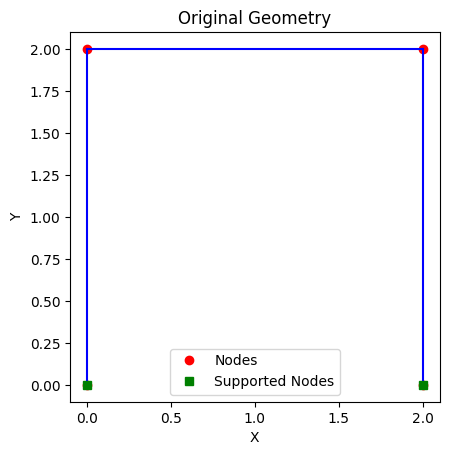

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])

# Function to plot the original geometry
def plot_geometry(nodes, elements, supp):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')
    
    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')
    
    # Highlight supported nodes
    for node in supp[:, 0]:
        ax.plot(nodes[node, 0], nodes[node, 1], 'gs', label='Supported Nodes' if node == supp[0, 0] else "")
    
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Original Geometry')
    plt.legend()
    plt.show()

# Plot the original geometry
plot_geometry(nodes, elements, supp)

In [66]:
num_elements_per_edge = 2

x_coords = np.linspace(0, L, num_elements_per_edge + 1)
y_coords = np.linspace(0, L, num_elements_per_edge + 1)

top_nodes = np.array([[x, L] for x in x_coords if x != 0])
left_nodes = np.array([[0, y] for y in y_coords])
right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

nodes = np.vstack([left_nodes, top_nodes, right_nodes])

elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
flatten_elements = elements.flatten()

supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

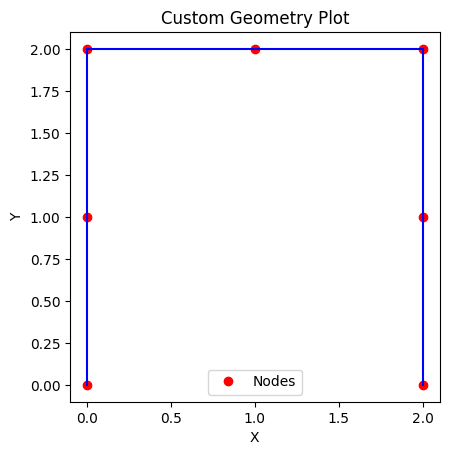

In [67]:
def plot_nodes(nodes):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

# Plot the nodes
plot_nodes(nodes)

In [68]:
# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.44133539e-04
 -1.66666667e-04  1.37341906e-04  2.71665308e-05 -3.33333333e-04
 -6.30867216e-04 -9.29349757e-20 -8.80248423e-04 -9.60632642e-21
 -2.71665308e-05 -3.33333333e-04  6.30867216e-04  1.44133539e-04
 -1.66666667e-04 -1.37341906e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
#########################################################


In [69]:
# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.relu(layer(z))
        
        # Final output layer
        z = self.fout(z)
        
        return z

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
layers = [128, 128, 256, 256, 512, 512, 512]
model = BeamApproximator(input_dim, layers, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

In [70]:
epochs = 40000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 190389534720.0
Epoch: 2, Loss: 1916686198374400.0
Epoch: 3, Loss: 157867425792.0
Epoch: 4, Loss: 665386090496.0
Epoch: 5, Loss: 546932883456.0
Epoch: 6, Loss: 37449338880.0
Epoch: 7, Loss: 31606028288.0
Epoch: 8, Loss: 227471360000.0
Epoch: 9, Loss: 326253215744.0
Epoch: 10, Loss: 165241192448.0
Epoch: 11, Loss: 18874294272.0
Epoch: 12, Loss: 133977694208.0
Epoch: 13, Loss: 64910405632.0
Epoch: 14, Loss: 38104948736.0
Epoch: 15, Loss: 11994997760.0
Epoch: 16, Loss: 7985601536.0
Epoch: 17, Loss: 8972674048.0
Epoch: 18, Loss: 10667292672.0
Epoch: 19, Loss: 11235358720.0
Epoch: 20, Loss: 8510520832.0
Epoch: 21, Loss: 5716179968.0
Epoch: 22, Loss: 3814757376.0
Epoch: 23, Loss: 3874532608.0
Epoch: 24, Loss: 4311059456.0
Epoch: 25, Loss: 4760753664.0
Epoch: 26, Loss: 4734822912.0
Epoch: 27, Loss: 4483321344.0
Epoch: 28, Loss: 3735837696.0
Epoch: 29, Loss: 2655783680.0
Epoch: 30, Loss: 1736733312.0
Epoch: 31, Loss: 1375551232.0
Epoch: 32, Loss: 1785016064.0
Epoch: 33, Loss: 23

In [71]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

def compute_energy_error(K, uh_fem, uh_nn):
    """
    Compute the energy error between the FEM and NN solutions.

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: Energy error as a scalar
    """
    # Ensure all tensors are of the same type (float32)
    K = K.float()
    uh_fem = uh_fem.float()
    uh_nn = uh_nn.float()
    
    # Compute strain energy for FEM and NN solutions
    U_fem = 0.5 * torch.matmul(uh_fem.T, torch.matmul(K, uh_fem))
    U_nn = 0.5 * torch.matmul(uh_nn.T, torch.matmul(K, uh_nn))

    # Compute energy error
    energy_error = (U_nn - U_fem) / U_fem
    return energy_error.abs()  # Return the absolute value of the error

import torch

def compute_h1_norm(K, uh_fem, uh_nn):
    """
    Compute the H1 norm between the FEM and NN solutions.
    
    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: H1 norm error as a scalar
    """
    # Ensure all tensors are of the same type and have requires_grad=True
    uh_fem = uh_fem.float().requires_grad_(True)
    uh_nn = uh_nn.float().requires_grad_(True)

    # Compute L2 norm of the displacement field
    l2_error = torch.norm(uh_nn - uh_fem) ** 2

    # Compute gradient (strain) of the displacement fields
    grad_uh_fem = torch.autograd.grad(uh_fem.sum(), uh_fem, create_graph=True)[0]
    grad_uh_nn = torch.autograd.grad(uh_nn.sum(), uh_nn, create_graph=True)[0]

    # Compute L2 norm of the gradient (strain)
    grad_error = torch.norm(grad_uh_nn - grad_uh_fem) ** 2

    # Combine L2 norm of the displacement and gradient
    h1_error = torch.sqrt(l2_error + grad_error)

    return h1_error

In [72]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

l2_error = compute_l2_error(torch.tensor(uh_vem), predicted_displacements).item()
energy_error = compute_energy_error(K, torch.tensor(uh_vem), predicted_displacements).item()
h1_error = compute_h1_norm(K, torch.tensor(uh_vem), predicted_displacements).item()

print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([-3.9775e-07, -7.3669e-05,  7.4421e-10, -5.6784e-06,  4.8689e-04,
         4.1952e-05, -1.4648e-04, -9.8896e-04, -1.0486e-03, -1.6425e-05,
        -2.6478e-04, -2.1420e-04, -1.2220e-04, -7.3370e-04,  9.3900e-04,
         7.1665e-05,  2.2399e-04, -6.3105e-05,  9.6673e-09, -7.0074e-06,
        -6.7437e-06])
L2 error: 1.0048270197878655
Energy error: 20.01670265197754
H1 error: 0.0013957160990685225


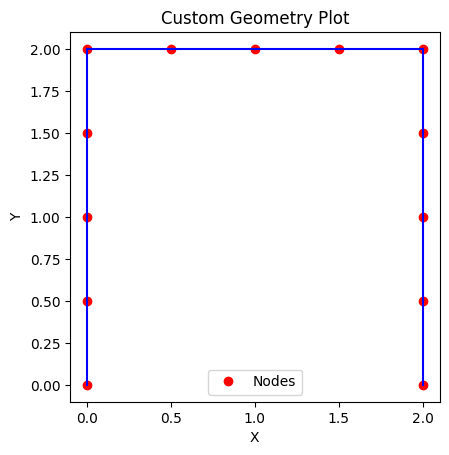


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.02895092e-06
 -8.92347406e-05  3.50292908e-06 -2.21989101e-06 -1.78469481e-04
 -7.35204331e-06  9.06325122e-06 -2.46870888e-04 -4.23934002e-05
 -8.95727676e-05 -2.73605629e-04  4.32324601e-04 -9.12334024e-05
 -1.03010644e-04  2.66448138e-04 -9.28940373e-05 -1.84706139e-05
  8.81047799e-05 -9.45546721e-05 -2.97386807e-06 -9.72499864e-06
 -9.62153070e-05  2.36056291e-05  1.32435785e-04 -4.02876350e-05
  1.77042218e-05  9.58877773e-05 -8.57068980e-06  1.18028146e-05
  3.55928779e-05  1.63764844e-07  5.90140728e-06  3.95781521e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00]
#########################################################
Epoch: 1, Loss: 2306750545920.0
Epoch: 2, Loss: 3388666544128.0
Epoch: 3, Loss: 609052590080.0
Epoch: 4, Loss: 249839484928.0
Epoch: 5, Loss: 652136611840.0
Epoch: 6, Loss: 595798523904.0
Epoch: 7, Loss: 292931076096.0
Epoch: 8, Loss: 88020975616.0

In [73]:
num_elements_per_edge = 4

x_coords = np.linspace(0, L, num_elements_per_edge + 1)
y_coords = np.linspace(0, L, num_elements_per_edge + 1)

top_nodes = np.array([[x, L] for x in x_coords if x != 0])
left_nodes = np.array([[0, y] for y in y_coords])
right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

nodes = np.vstack([left_nodes, top_nodes, right_nodes])

elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
flatten_elements = elements.flatten()

supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

def plot_nodes(nodes):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

# Plot the nodes
plot_nodes(nodes)

# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.relu(layer(z))
        
        # Final output layer
        z = self.fout(z)
        
        return z

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
layers = [128, 128, 256, 256, 512, 512, 512, 1024]
model = BeamApproximator(input_dim, layers, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.001)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

epochs = 70000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

In [74]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

l2_error = compute_l2_error(torch.tensor(uh_vem), predicted_displacements).item()
energy_error = compute_energy_error(K, torch.tensor(uh_vem), predicted_displacements).item()
h1_error = compute_h1_norm(K, torch.tensor(uh_vem), predicted_displacements).item()

print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

Predicted displacements: tensor([ 7.9937e-13, -3.1604e-09, -3.6869e-06, -3.4651e-06, -8.2228e-05,
         5.0548e-06, -4.2039e-07, -1.8576e-04, -1.1112e-05,  6.4046e-06,
        -2.3916e-04, -3.7556e-05, -8.5263e-05, -2.8314e-04,  4.2855e-04,
        -9.9660e-05, -8.8185e-05,  2.9690e-04, -7.9622e-05, -4.2264e-05,
         6.5036e-05, -1.1280e-04,  2.7762e-05,  1.7581e-06, -7.4178e-05,
        -9.5544e-06,  1.6315e-04, -6.2139e-05,  5.1587e-05,  9.6188e-05,
         1.1263e-05, -2.2111e-05,  1.1122e-05, -1.7971e-05,  3.9793e-05,
         2.2922e-05, -4.1741e-10, -1.0177e-10, -6.4202e-11])
L2 error: 0.15313835734998824
Energy error: 2.1587483882904053
H1 error: 0.00011129938502563164


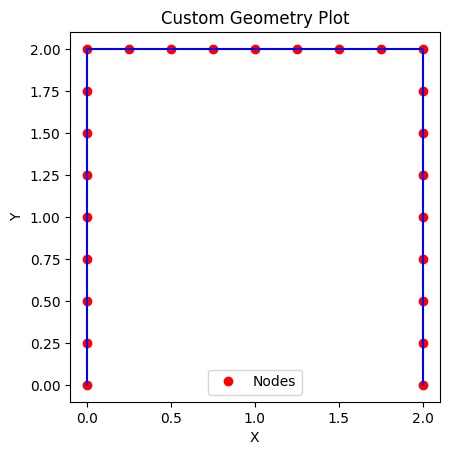


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.17339955e-08
 -2.14427330e-05  2.27723133e-07  1.12629721e-07 -4.28854659e-05
 -1.24878169e-06  2.62794616e-07 -5.91198655e-05  1.01313694e-07
 -2.80378315e-08 -6.49375985e-05  2.27919706e-06 -3.96031942e-10
 -6.55469981e-05 -2.44648029e-06 -9.34621382e-07 -6.61563978e-05
  9.97413425e-06  4.01151099e-06 -6.67657974e-05 -4.94893421e-05
 -1.90264993e-05 -6.73751970e-05  2.33847275e-04 -1.89877264e-05
 -2.13883922e-05  1.34893551e-04 -1.89489536e-05 -3.95818289e-07
  3.38934285e-05 -1.89101807e-05  3.21478705e-06 -4.16219740e-06
 -1.88714079e-05  1.64297824e-06 -7.56588465e-06 -1.88326351e-05
  1.15968873e-07 -3.80380196e-06 -1.87938622e-05 -1.31417160e-07
  2.67110206e-06 -1.87550894e-05 -1.49977127e-06 -1.27715466e-05
 -1.87163165e-05  4.87519701e-06  6.46176812e-05 -5.93255208e-06
  4.26579739e-06  3.75985832e-05 -4.48395776e-08  3.65639776e-06
  9.44926570e-06  9.87875854e-0

In [78]:
num_elements_per_edge = 8

x_coords = np.linspace(0, L, num_elements_per_edge + 1)
y_coords = np.linspace(0, L, num_elements_per_edge + 1)

top_nodes = np.array([[x, L] for x in x_coords if x != 0])
left_nodes = np.array([[0, y] for y in y_coords])
right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

nodes = np.vstack([left_nodes, top_nodes, right_nodes])

elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
flatten_elements = elements.flatten()

supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

def plot_nodes(nodes):
    fig, ax = plt.subplots()
    
    # Plot nodes
    ax.plot(nodes[:, 0], nodes[:, 1], 'ro', label='Nodes')

    # Plot elements as lines connecting nodes
    for element in elements:
        element_coords = nodes[element]
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Custom Geometry Plot')
    plt.legend()
    plt.show()

# Plot the nodes
plot_nodes(nodes)

# geometry data
L = 2.0
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[2,3],[3,4]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, layers, ndof):
        super(BeamApproximator, self).__init__()
        # First layer from input to the first hidden layer
        self.fin = nn.Linear(input_dim, layers[0])
        
        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Final output layer from the last hidden layer to the output (ndof)
        self.fout = nn.Linear(layers[-1], ndof)

    def forward(self, x):
        # Pass through the first layer
        z = torch.relu(self.fin(x))
        
        # Pass through the hidden layers
        for layer in self.hidden:
            z = torch.relu(layer(z))
        
        # Final output layer
        z = self.fout(z)
        
        return z

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
# layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024]
layers = [128, 256, 256, 512, 512, 512]
model = BeamApproximator(input_dim, layers, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.0000000001, weight_decay=1e-4)
# optimizer = optim.RMSprop(model.parameters(), lr=0.0000000001)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

epochs = 20000
sub_epochs = 1000
loss_buffer = float('inf')  # Initialize with a large value

for epoch in range(epochs):
    for sub_epoch in range(sub_epochs):
        optimizer.zero_grad()
        uh = model(nodes)
        
        # Compute the loss
        loss = compute_loss(K, uh, f)
        loss_bc = compute_boundary_loss(uh, supp)
        total_loss = loss + loss_bc
        
        # Only update the model if the new loss is smaller than the loss_buffer
        
        total_loss.backward()
        optimizer.step()
        loss_buffer = total_loss.item()  # Update the loss buffer with the new smaller loss
        
        print(f'Epoch: {epoch + 1}, Sub-epoch: {sub_epoch + 1}, Loss: {total_loss.item()}')
    
    # Early stopping condition if the loss is not improving
    if total_loss.item() >= loss_buffer:
        print(f'Early stopping at epoch {epoch + 1} as the loss is not improving.')
        break
    
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

l2_error = compute_l2_error(torch.tensor(uh_vem), predicted_displacements).item()
energy_error = compute_energy_error(K, torch.tensor(uh_vem), predicted_displacements).item()
h1_error = compute_h1_norm(K, torch.tensor(uh_vem), predicted_displacements).item()

print(f"L2 error: {l2_error}")
print(f"Energy error: {energy_error}")
print(f"H1 error: {h1_error}")

In [76]:
def generate_geometry(num_elements_per_edge: int)->Tuple[np.ndarray, np.ndarray, np.ndarray]:
    x_coords = np.linspace(0, L, num_elements_per_edge + 1)
    y_coords = np.linspace(0, L, num_elements_per_edge + 1)

    top_nodes = np.array([[x, L] for x in x_coords if x != 0])
    left_nodes = np.array([[0, y] for y in y_coords])
    right_nodes = np.array([[L, y] for y in reversed(y_coords) if y != L])

    nodes = np.vstack([left_nodes, top_nodes, right_nodes])

    elements = np.array([[i, i+1] for i in range(len(nodes)-1)])
    flatten_elements = elements.flatten()

    supp = np.array([[flatten_elements[0], 1, 1, 1], [flatten_elements[-1], 1, 1, 1]])

    return nodes, elements, supp

def solve_vem(nodes: np.ndarray, elements: np.ndarray, supp: np.ndarray)->np.ndarray:
    I = 36e-4
    A = 0.12

    # material data
    E = 20e6

    # loads
    load = np.array([[2,3],[3,4]])
    q = -400
    t = 0
    f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

    # stiffness matrix
    K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

    # apply DBC
    K, f = vem.applyDBCBeam(K, f_dist, supp)

    # solve
    uh_vem = np.linalg.solve(K,f)

    return uh_vem, K, f